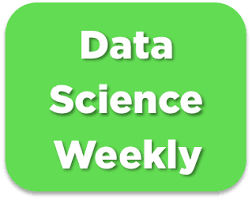

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

 ## IMPORT MODULES

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, r2_score
from sklearn.feature_selection import f_regression

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

 ## MODEL IMPORTING (DATASET WITH LABELS)

In [4]:
# File without labels
# data2 = pd.read_csv('conversion_data_test.csv')
# data2.head()

In [5]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [6]:
data.head(2)

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0


## EXPLORING DATASET

In [7]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [8]:
display([col for col in data.columns])
summary_table = pd.DataFrame({
    'is_null_value': data.isnull().any(),
    # 'sum_null_value': data.isnull().sum(),
    # 'proporcion_null_value': (data.isnull().sum()/data.shape[0])*100,
    'count_values': data.count(),
    # 'unique': {print(f'{len(data.groupby(col).Name.nunique())}') for col in data},
    'type': data.dtypes,
    'mean': data.mean(),
    'max': data.max(),
    'min': data.min(),
})
summary_table

['country', 'age', 'new_user', 'source', 'total_pages_visited', 'converted']

,is_null_value,count_values,type,mean,max,min
age,False,284580,int64,30.564203,123,17
converted,False,284580,int64,0.032258,1,0
country,False,284580,object,NaN,US,China
new_user,False,284580,int64,0.685452,1,0
source,False,284580,object,NaN,Seo,Ads
total_pages_visited,False,284580,int64,4.873252,29,1


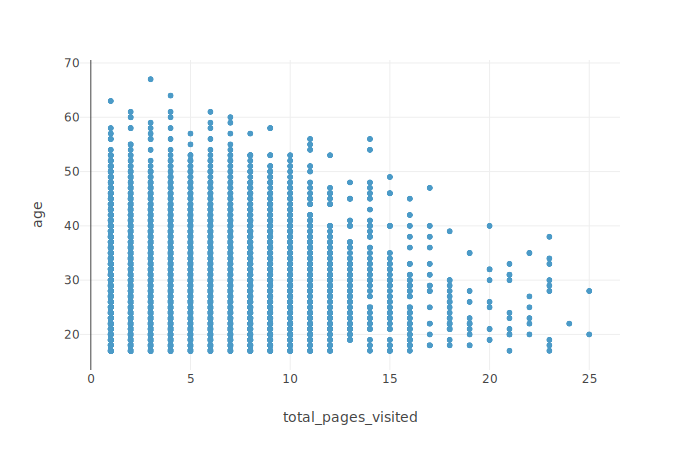

In [9]:
px.scatter(data_sample, x = 'total_pages_visited', y = 'age')

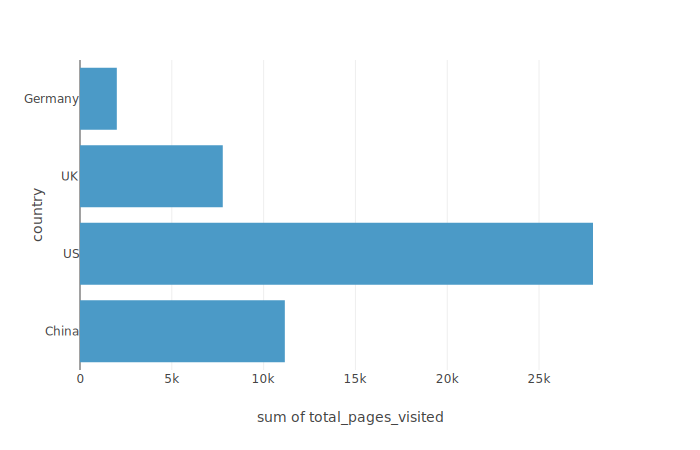

In [10]:
px.histogram(data_sample, x = 'total_pages_visited', y = 'country')

 ## PREPROCESSING - PANDAS 🐼🐼


Nothing wierd with columns.

👌 TARGET (Y) --> 'converted' column.

In [11]:
features_list = ['country','source', 'total_pages_visited', 'new_user', 'age']
target_variable = 'converted'

In [33]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

 ## PREPROCESSING - SCIKIT-LEARN 🔬🔬


We need to identify which columns contain categorical variables and which columns contain numerical variables, as they will be treated differently.

🖐 FEATURES (X)--> We have both, categorical variables and Numerical ones.

**👉 Categorical variables : 'country' , 'source'.**

**👉 Numerical variables : 'age', 'new_user', 'total_pages_visited', 'converted'**


🖐 TARGET (Y)--> It´s a categorical variable, it will thus, be necessary to provide an encoding with the LabelEncoder class.

**👉 Categorical variable : 'converted'.**

### TRAIN TEST SPLIT 🔬🔬

In [34]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
display(X_train.head(), Y_train.head())
display(X_test.head(), Y_test.head())
print()

Dividing into train and test sets...


,country,source,total_pages_visited,new_user,age
17050,US,Seo,4,1,29
260342,US,Direct,7,0,23
278164,UK,Seo,11,1,33
268440,China,Seo,5,1,25
157837,US,Seo,1,0,40


17050     0
260342    0
278164    0
268440    0
157837    0
Name: converted, dtype: int64

,country,source,total_pages_visited,new_user,age
149371,US,Ads,7,1,20
221325,US,Seo,5,1,31
14016,US,Seo,4,0,28
257982,Germany,Ads,4,1,25
59983,US,Ads,7,0,44


149371    0
221325    0
14016     0
257982    0
59983     0
Name: converted, dtype: int64

In [37]:
X_train['country'].value_counts()
X_train['source'].value_counts()

Seo       111617
Ads        63979
Direct     52068
Name: source, dtype: int64

### PIPELINE NUMERIC FEATURES

In [38]:
# SimpleImputer es una instancia de clase.
numeric_indices = [2,3,4] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

### PIPELINE CATEGORICAL FEATURES

In [39]:
# Create pipeline for categorical features
categorical_indices = [0,1] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

### PIPELINE GLOBAL

In [40]:
#Reminder: you need to call .fit_transform() on X_train and only .transform() on X_test, to ensure that the latter gets the same transformations as X_train.
# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train)
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train)
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test)
X_test = preprocessor.transform(X_test) # Don't fit again !!
print('...Done.')
print(X_test)
print()

Performing preprocessings on train set...
       country  source  total_pages_visited  new_user  age
17050       US     Seo                    4         1   29
260342      US  Direct                    7         0   23
278164      UK     Seo                   11         1   33
268440   China     Seo                    5         1   25
157837      US     Seo                    1         0   40
...        ...     ...                  ...       ...  ...
211543      US     Ads                    4         1   36
86293       US     Seo                    5         1   37
122579      UK  Direct                    6         1   31
152315      UK     Seo                    5         1   25
117952      US     Ads                    3         1   34

[227664 rows x 5 columns]
...Done.
[[-0.26094223  0.67687527 -0.19030813 ...  1.          0.
   1.        ]
 [ 0.63598611 -1.47737706 -0.9161838  ...  1.          1.
   0.        ]
 [ 1.83189056  0.67687527  0.29360899 ...  0.          0.
   1.     

In [17]:
X_train[0]

array([-0.26094223,  0.67687527, -0.19030813,  0.        ,  0.        ,
        1.        ,  0.        ,  1.        ])

### ENCODE TARGET VARIABLE Y

In [41]:
labelencoder = LabelEncoder()

print("Encoding labels on train set...")
print(Y_train)
print()
Y_train = labelencoder.fit_transform(Y_train)
print("...Done.")
print(Y_train)
print()

Encoding labels on train set...
17050     0
260342    0
278164    0
268440    0
157837    0
         ..
211543    0
86293     0
122579    0
152315    0
117952    0
Name: converted, Length: 227664, dtype: int64

...Done.
[0 0 0 ... 0 0 0]



In [42]:
print("Encoding labels on test set...")
print(Y_test)
print()
Y_test = labelencoder.transform(Y_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print("...Done.")
print(Y_test)
print()

Encoding labels on test set...
149371    0
221325    0
14016     0
257982    0
59983     0
         ..
22268     0
58724     0
80402     0
69384     0
189402    0
Name: converted, Length: 56916, dtype: int64

...Done.
[0 0 0 ... 0 0 0]



## MODEL TRAINING 🏃

In [20]:
# Train model
model = LogisticRegression(random_state=0)

print("Training model...")
model.fit(X_train, Y_train) # Training is always done on train set !!
print("...Done.")

Training model...
...Done.


## PREDICTIONS 🔮

In [21]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [22]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



### PERFORMANCE 💯

In [23]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7650256720024163
f1-score on test set :  0.7581423401688782


In [24]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219486    848]
 [  2264   5066]]

Confusion matrix on test set : 
[[54857   209]
 [  593  1257]]



**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [43]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

# classifier = LogisticRegression()
model.fit(X,Y)

LogisticRegression(random_state=0)

In [45]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
# features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# # Convert pandas DataFrames to numpy arrays before using scikit-learn
# print("Convert pandas DataFrames to numpy arrays...")
# X_without_labels = X_without_labels.values
# print("...Done")

print(X_without_labels[:5])

Prediction set (without labels) : (31620, 5)
  country  source  total_pages_visited  new_user  age
0      UK     Seo                   16         0   28
1      UK  Direct                    5         1   22
2   China     Seo                    1         1   32
3      US     Ads                    6         1   32
4   China     Seo                    3         0   25


In [46]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")



# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_without_labels)
X_without_labels = preprocessor.transform(X_without_labels)
print('...Done.')
print(X_without_labels)
print()

Encoding categorical features and standardizing numerical features...
Performing preprocessings on test set...
       country  source  total_pages_visited  new_user  age
0           UK     Seo                   16         0   28
1           UK  Direct                    5         1   22
2        China     Seo                    1         1   32
3           US     Ads                    6         1   32
4        China     Seo                    3         0   25
...        ...     ...                  ...       ...  ...
31615  Germany     Seo                    3         1   25
31616       US     Ads                    7         1   36
31617       UK     Seo                    5         1   33
31618       UK     Seo                   14         1   25
31619       US     Seo                    2         1   22

[31620 rows x 5 columns]
...Done.
[[ 3.32677112 -1.47737706 -0.3112874  ...  0.          0.
   1.        ]
 [ 0.03803388  0.67687527 -1.03716308 ...  0.          1.
   0.        ]


In [47]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': model.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_JAVI-model1.csv', index=False)
Y_predictions.head()


,converted
0,1
1,0
2,0
3,0
4,0


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**